In [1]:
site = 'addis_ababa'



scenario = "ssp245"
#scenario = "ssp585"

In [2]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.1 MB/s eta 0:00:00


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
from prophet import Prophet
#from neuralprophet import NeuralProphet
#from fbprophet import Prophet
import matplotlib.pyplot as plt
import pickle
import cftime
import os
import sys

In [6]:
#path = '/content/drive/MyDrive/Precipitation_Projection_AIMS/'

calib_start = pd.to_datetime('1985-01-01')
valid_end = pd.to_datetime('2014-12-31')

n_days = (valid_end - calib_start).days
n_calib = int(n_days*0.8)

calib_end = calib_start + pd.Timedelta(days=n_calib)

valid_start = calib_end + pd.Timedelta(days=1)
valid_end = valid_start + pd.Timedelta(days=n_days-n_calib)

projection_start = pd.to_datetime('2015-01-01')
projection_end = pd.to_datetime('2100-12-31')


print(f"Calibration period: {calib_start} to {calib_end}")
print(f"Validation period: {valid_start} to {valid_end}")

Calibration period: 1985-01-01 00:00:00 to 2008-12-30 00:00:00
Validation period: 2008-12-31 00:00:00 to 2015-01-01 00:00:00


In [7]:
path = '/content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/'
if os.path.exists(path):
  sys.path.append(path)
else:
  path = os.getcwd()

print(f'path: {path}')
assert os.path.exists(path+ f'data/{site}')
directory_data = path + f'data/{site}/'

directory_training = directory_data + scenario + "/" + "training/"
directory_validation = directory_data + scenario + "/" + "validation/"
directory_projection = directory_data + scenario + "/" + "projection/"

if not os.path.exists(directory_training):
  os.makedirs(directory_training)
if not os.path.exists(directory_validation):
  os.makedirs(directory_validation)
if not os.path.exists(directory_projection):
  os.makedirs(directory_projection)

path: /content/drive/MyDrive/NTHESE/Precipitation_Projection_AIMS-20250531T225815Z-1-001/Precipitation_Projection_AIMS/


In [8]:
import dqm
import manage_files

In [9]:
data_obs = xr.open_dataset(directory_data + f'precip_cpc_{site}.nc')
data_hist = xr.open_dataset(directory_data + f'pr_historical_{site}_ensmean.nc')
data_model = xr.open_dataset(directory_data + f'pr_{scenario}_{site}_ensmean.nc')

In [10]:
# Convert to DataFrame and reset index to have 'time' as a column
df_hist = data_hist.to_dataframe()
df_hist = df_hist.reset_index()

#==============================================================
df_obs = data_obs.to_dataframe()
df_obs = df_obs.reset_index() # Reset the index to default integer index

#===========================================================
df_model = data_model.to_dataframe()
df_model = df_model.reset_index()

#===========================================================

print(f"{'df_hist':<7},  {str(df_hist.shape)},  {list(df_hist.columns)}")
print(f"{'df_obs':<7},  {str(df_obs.shape)},  {list(df_obs.columns)}")
print(f"df_{scenario},  {str(df_model.shape)},  {list(df_model.columns)}")

df_hist,  (10800, 4),  ['time', 'lon', 'lat', 'pr']
df_obs ,  (10592, 4),  ['time', 'lon', 'lat', 'precip']
df_ssp245,  (30960, 4),  ['time', 'lon', 'lat', 'pr']


In [11]:
# prompt: écrire une fonction pour afficher le nombre de points de collecte presen dans chaque dataframe (cela en comptant le nombre de pairs longitude-latitude différente), afficher le pas de temps dans chaque df, ainisi que les dates de debut de collecte et de fin

def analyze_dataframes(dfs):
  """
  Analyze a list of dataframes to display information about collection points,
  time step, and start/end dates.

  Args:
    dfs: A dictionary where keys are dataframe names and values are the dataframes.
  """
  for name, df in dfs.items():
    print(f"--- Analysis for {name} ---")

    # Count unique latitude-longitude pairs (collection points)
    if 'lat' in df.columns and 'lon' in df.columns:
      unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
      print(f"Number of collection points: {unique_points}")
      print(df[['lat', 'lon']].drop_duplicates())

    else:
      print("Latitude and longitude columns not found.")

    # Determine time step
    if 'time' in df.columns and len(df['time']) > 1:
        # Ensure time column is datetime type
        if not pd.api.types.is_datetime64_any_dtype(df['time']):
            try:
                df['time'] = pd.to_datetime(df['time'])
            except Exception as e:
                print(f"Could not convert 'time' column to datetime: {e}")
                time_step = "Unknown (time conversion failed)"
                start_date = "Unknown (time conversion failed)"
                end_date = "Unknown (time conversion failed)"
                continue # Skip to the next dataframe
        else:
            time_diffs = df['time'].diff().dropna()
            if len(time_diffs) > 0:
                time_step = time_diffs.mode()[0]
                print(f"Estimated time step: {time_step}")
            else:
                time_step = "Cannot determine time step (less than 2 time entries)"
                print(time_step)

        # Display start and end dates
        start_date = df['time'].min()
        end_date = df['time'].max()
        print(f"Start date: {start_date}")
        print(f"End date: {end_date}")

    else:
      print("Time column not found or insufficient data.")

    print("-" * (len(f"--- Analysis for {name} --- \n")))


# Create a dictionary of your dataframes
dataframes = {
    'df_hist': df_hist,
    'df_obs': df_obs,
    f'df_{scenario}': df_model
}

# Call the function with your dictionary of dataframes
analyze_dataframes(dataframes)


--- Analysis for df_hist ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 12:00:00
End date: 2014-07-27 12:00:00
------------------------------
--- Analysis for df_obs ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 1985-01-01 00:00:00
End date: 2014-12-31 00:00:00
-----------------------------
--- Analysis for df_ssp245 ---
Number of collection points: 1
     lat      lon
0  9.005  38.7636
Estimated time step: 1 days 00:00:00
Start date: 2015-01-01 12:00:00
End date: 2099-10-06 12:00:00
--------------------------------


In [12]:
# Create a dictionary and standardize the precipitation column name to 'precip' for easier processing
df_s = {'obs': df_obs, 'hist' : df_hist, scenario : df_model}

for key, val in df_s.items():
    df_s[key] = val.copy()
    # Find the column containing 'precip' (case-insensitive) and rename to 'precip'
    col_precip_list = [col for col in df_s[key].columns if 'precip' in col.lower()]
    if not col_precip_list:
        # This should not happen if the previous renames worked, but as a safety check
        print(f"Warning: No column containing 'precip' found in dataframe '{key}'. Columns are: {df_s[key].columns}")
        # Attempt to find a 'pr' column if 'precip' wasn't found after rename (fallback)
        col_precip_list = [col for col in df_s[key].columns if 'pr' in col.lower()]
        if not col_precip_list:
             raise ValueError(f"Could not find 'precip' or 'pr' column in dataframe '{key}'. Cannot proceed.")

    col_precip = col_precip_list[0] # Take the first match
    if col_precip != 'precip': # Only rename if the name isn't already 'precip'
         df_s[key].rename(columns={col_precip: 'precip'}, inplace=True)

    # Ensure 'time' is datetime and normalize to remove time component
    # Use errors='coerce' to turn invalid parsing into NaT (Not a Time)
    #df_s[key]['time'] = pd.to_datetime(df_s[key]['time'], errors='coerce').dt.normalize()

    df_s[key]['time'] = df_s[key]['time'].dt.strftime('%Y-%m-%d')
    df_s[key]['time'] = pd.to_datetime(df_s[key]['time'])
    df_s[key]['time'] = df_s[key]['time'].dt.normalize()

    # Drop rows where time conversion failed - crucial!
    df_s[key].dropna(subset=['time', 'precip'], inplace=True)

    df_s[key] = df_s[key].sort_values(by='time').reset_index(drop=True)
    df_s[key] = df_s[key][['time', 'precip']]


# Assign to underscore variables for clarity in subsequent steps
_obs = df_s['obs'].copy()
_hist = df_s['hist'].copy()
_scenar = df_s[scenario].copy()

# --- Check number of unique collection points (copied from previous suggestion) ---
dataframes_to_check = {'_hist': _hist, '_obs': _obs, scenario: _scenar}

print("\n--- Checking Collection Points ---")
for name, df in dataframes_to_check.items():

    if 'lat' in df.columns and 'lon' in df.columns:
        unique_points = df[['lat', 'lon']].drop_duplicates().shape[0]
        print(f"Number of unique (lat, lon) points in {name}: {unique_points}")
        if unique_points > 1:
            print(f"  --> Warning: {name} contains multiple collection points.")
            print("      Consider spatially averaging the precipitation data before bias correction if you need a single regional time series.")

    else:
        print(f"\nLatitude and longitude columns not found in {name}. Assuming a single location or pre-averaged data.")
print("\n--- Collection Point Check Complete ---")


# --- Determine the common calibration period based on overlapping dates ---
# This defines the target date range for calibration
date_1 = max(_obs['time'].min(), _hist['time'].min())
date_2 = min(_obs['time'].max(), _hist['time'].max())




--- Checking Collection Points ---

Latitude and longitude columns not found in _hist. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in _obs. Assuming a single location or pre-averaged data.

Latitude and longitude columns not found in ssp245. Assuming a single location or pre-averaged data.

--- Collection Point Check Complete ---


In [ ]:
print(f"\nTarget calibration period range based on max/min overlap: {date_1} to {date_2}")

# --- Filter dataframes to the target calibration period range ---
# Use .copy() to ensure these are independent DataFrames
_obs_calib_range = _obs[(_obs['time'] >= date_1) & (_obs['time'] <= date_2)].copy()
_hist_calib_range = _hist[(_hist['time'] >= date_1) & (_hist['time'] <= date_2)].copy()


_obs_aligned = _obs_calib_range
_hist_aligned = _hist_calib_range



Target calibration period range based on max/min overlap: 1985-01-02 00:00:00 to 2014-07-27 00:00:00


In [13]:
# --- Identify dates with NaNs in the observation data within the aligned data ---
# Ensure 'precip' column exists after potential resampling/filtering
if 'precip' not in _obs_aligned.columns:
     raise ValueError("'precip' column not found in _obs_aligned after alignment steps.")
if 'precip' not in _hist_aligned.columns:
     raise ValueError("'precip' column not found in _hist_aligned after alignment steps.")

assert _obs_aligned['time'].notna().all(), "Missing 'time' values in _obs_aligned"
assert _hist_aligned['time'].notna().all(), "Missing 'time' values in _hist_aligned"

n_obs_aligned_bf = len(_obs_aligned)
n_hist_aligned_bf = len(_hist_aligned)

# Drop rows with NaNs in the 'precip' column
_obs_aligned.dropna(inplace=True)
_hist_aligned.dropna(inplace=True)

print(f"\nNaN rows dropped from calibration _obs (after DropNa): ", 100-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"NaN rows dropped from calibration _hist (after DropNa): ", 100-100*len(_hist_aligned)/n_hist_aligned_bf)

common_times = _obs_aligned["time"].isin(_hist_aligned["time"])

# Filtrer les DataFrames
_obs_aligned = _obs_aligned[common_times].copy()
_hist_aligned = _hist_aligned[_hist_aligned["time"].isin(_obs_aligned["time"])].copy()

print(f"\nrows dropped from calibration _obs (after DropNa and alignement): ", 100.-100*len(_obs_aligned)/n_obs_aligned_bf)
print(f"rows dropped from calibration _hist (after DropNa and alignement): ", 100.-100*len(_hist_aligned)/n_hist_aligned_bf)

print(f'length _obs_aligned = {len(_obs_aligned)}')
print(f'length _obs_aligned = {len(_hist_aligned)}')


NameError: name '_obs_aligned' is not defined

In [14]:
assert len(_obs_aligned) == len(_hist_aligned), "Lengths of _obs_aligned and _hist_aligned are not equal."
assert _obs_aligned.shape == _hist_aligned.shape, "Shapes of _obs_aligned and _hist_aligned are not equal."


NameError: name '_obs_aligned' is not defined

In [ ]:
#_obs_aligned = _obs_aligned.reset_index(drop=True)
#_hist_aligned = _hist_aligned.reset_index(drop=True)

_obs_for_corrector = _obs_aligned.copy()
_hist_for_corrector = _hist_aligned.copy()

# Create the corrector instance with the aligned and cleaned data
# Pass the cleaned dataframes. The calibration period dates should match the range of these dataframes.


In [ ]:
if not(list(_obs_for_corrector.index) == list(range(len(_obs_for_corrector)))):
  _obs_for_corrector = _obs_for_corrector.reset_index(drop=True)

if not(list(_hist_for_corrector.index) == list(range(len(_hist_for_corrector)))):
  _hist_for_corrector = _hist_for_corrector.reset_index(drop=True)

In [ ]:
start = date_1
end   = date_2

split = int(len(_obs_for_corrector)*0.8)
ind_train = range(split)
ind_test = range(split, len(_obs_for_corrector))

In [ ]:
for i in range(len(_obs_for_corrector)):
    if _obs_for_corrector['time'].iloc[i] != _hist_for_corrector['time'].iloc[i]:
        print(f'index {i}: {_obs_for_corrector["time"].iloc[i]} != {_hist_for_corrector["time"].iloc[i]}')

In [ ]:
print(dir(manage_files))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'os', 'pd', 'save_metrics']


/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/training/dqm_précipitations (mm|jour).png


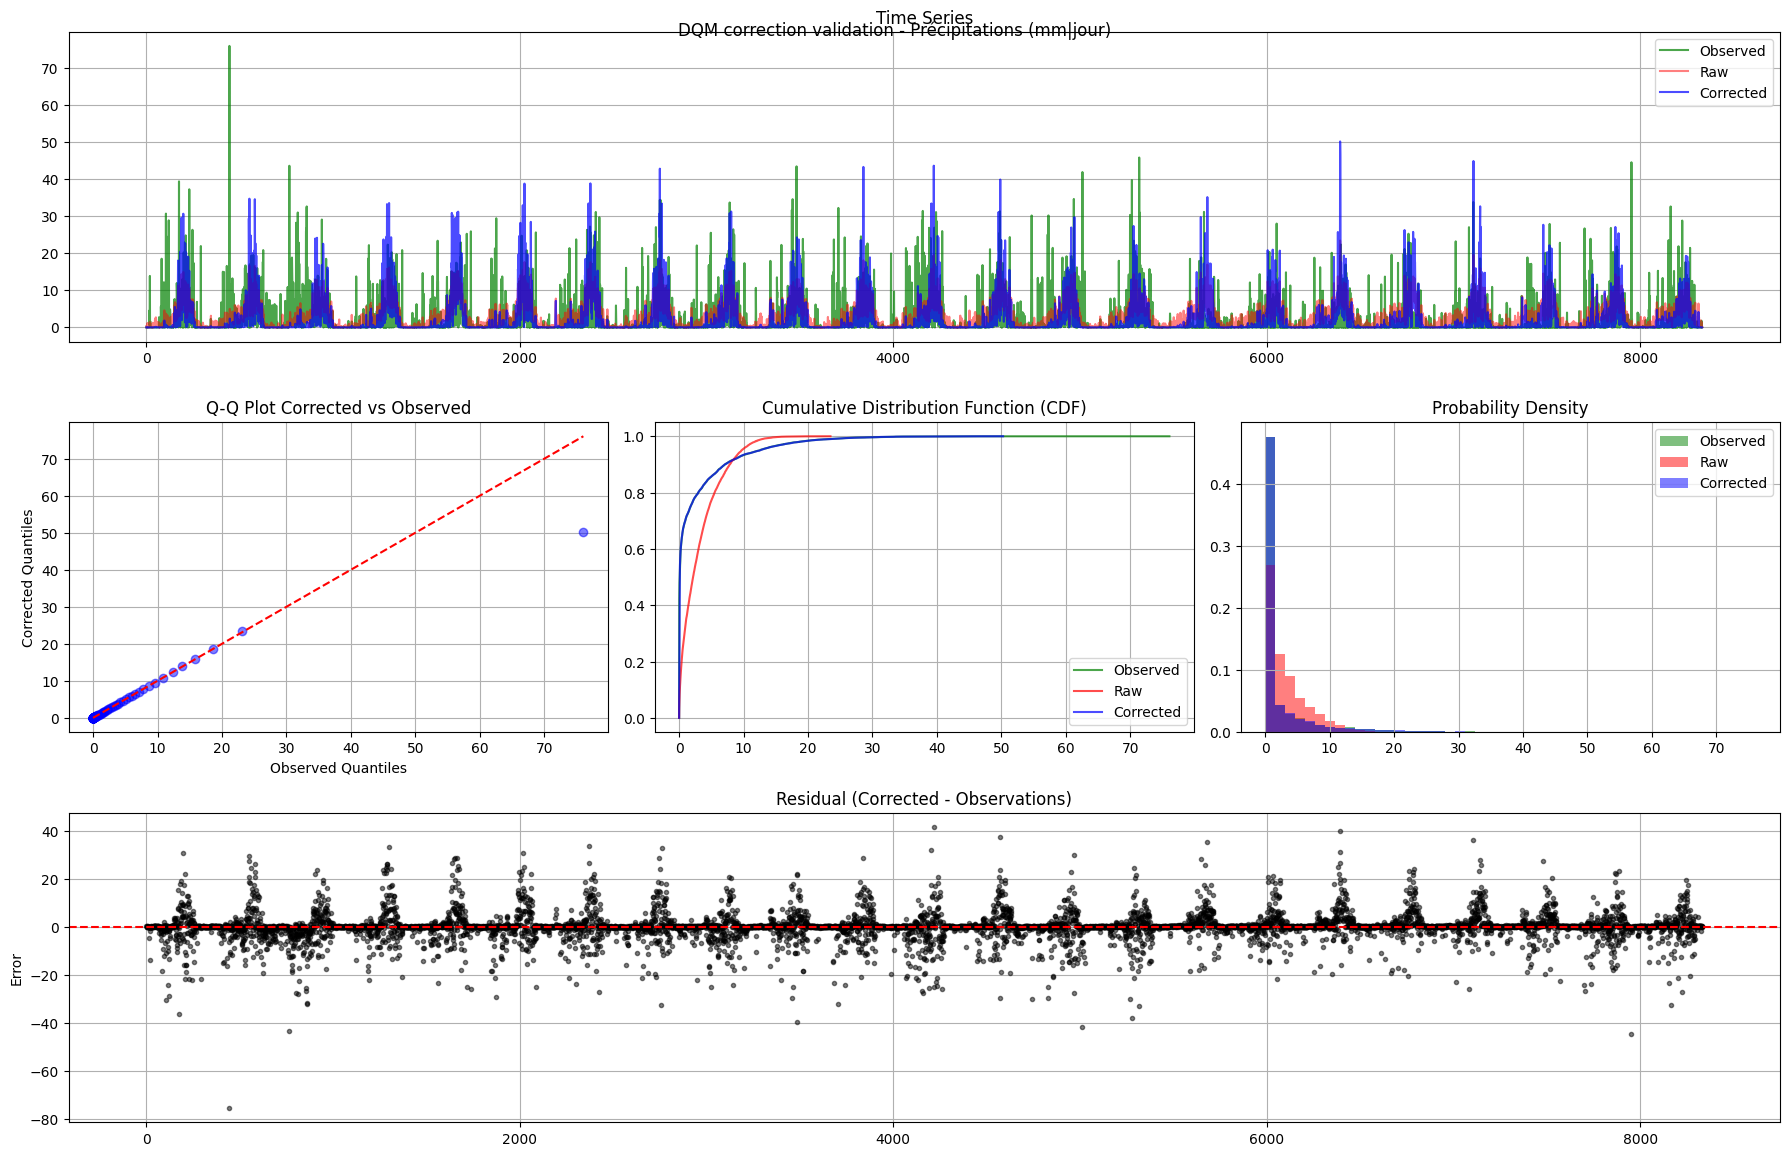

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/training/dqm_traning_mtrics.csv
{'RMSE Brut': np.float32(4.9495378), 'RMSE Corrige': np.float64(5.81188561607588), 'Biais Brut': np.float32(0.9851302), 'Biais Corrige': np.float64(0.01956173683691605), 'Corrélation Brut': np.float64(0.3188041146841261), 'Corrélation Corrige': np.float64(0.26720558699590574), 'KS-test p-value': np.float64(0.0)}


In [ ]:
# Entraînement sur la période historique
step = "training"
corrected_train, corrector = dqm.dqm(
    o=_obs_for_corrector.loc[ind_train, 'precip'].values,
    p=_hist_for_corrector.loc[ind_train, 'precip'].values,
    s=_hist_for_corrector.loc[ind_train, 'precip'].values,
    precip=True,
    pr_threshold=0.1
)

# Validation sur la période de test
metrics_train = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_train , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_train , 'precip'].values,
        corrected=corrected_train,
        directory=directory_training,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )

manage_files.save_metrics(metrics_train, 'dqm_traning_mtrics.csv', directory_training)
print(metrics_train)

/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_précipitations (mm|jour).png


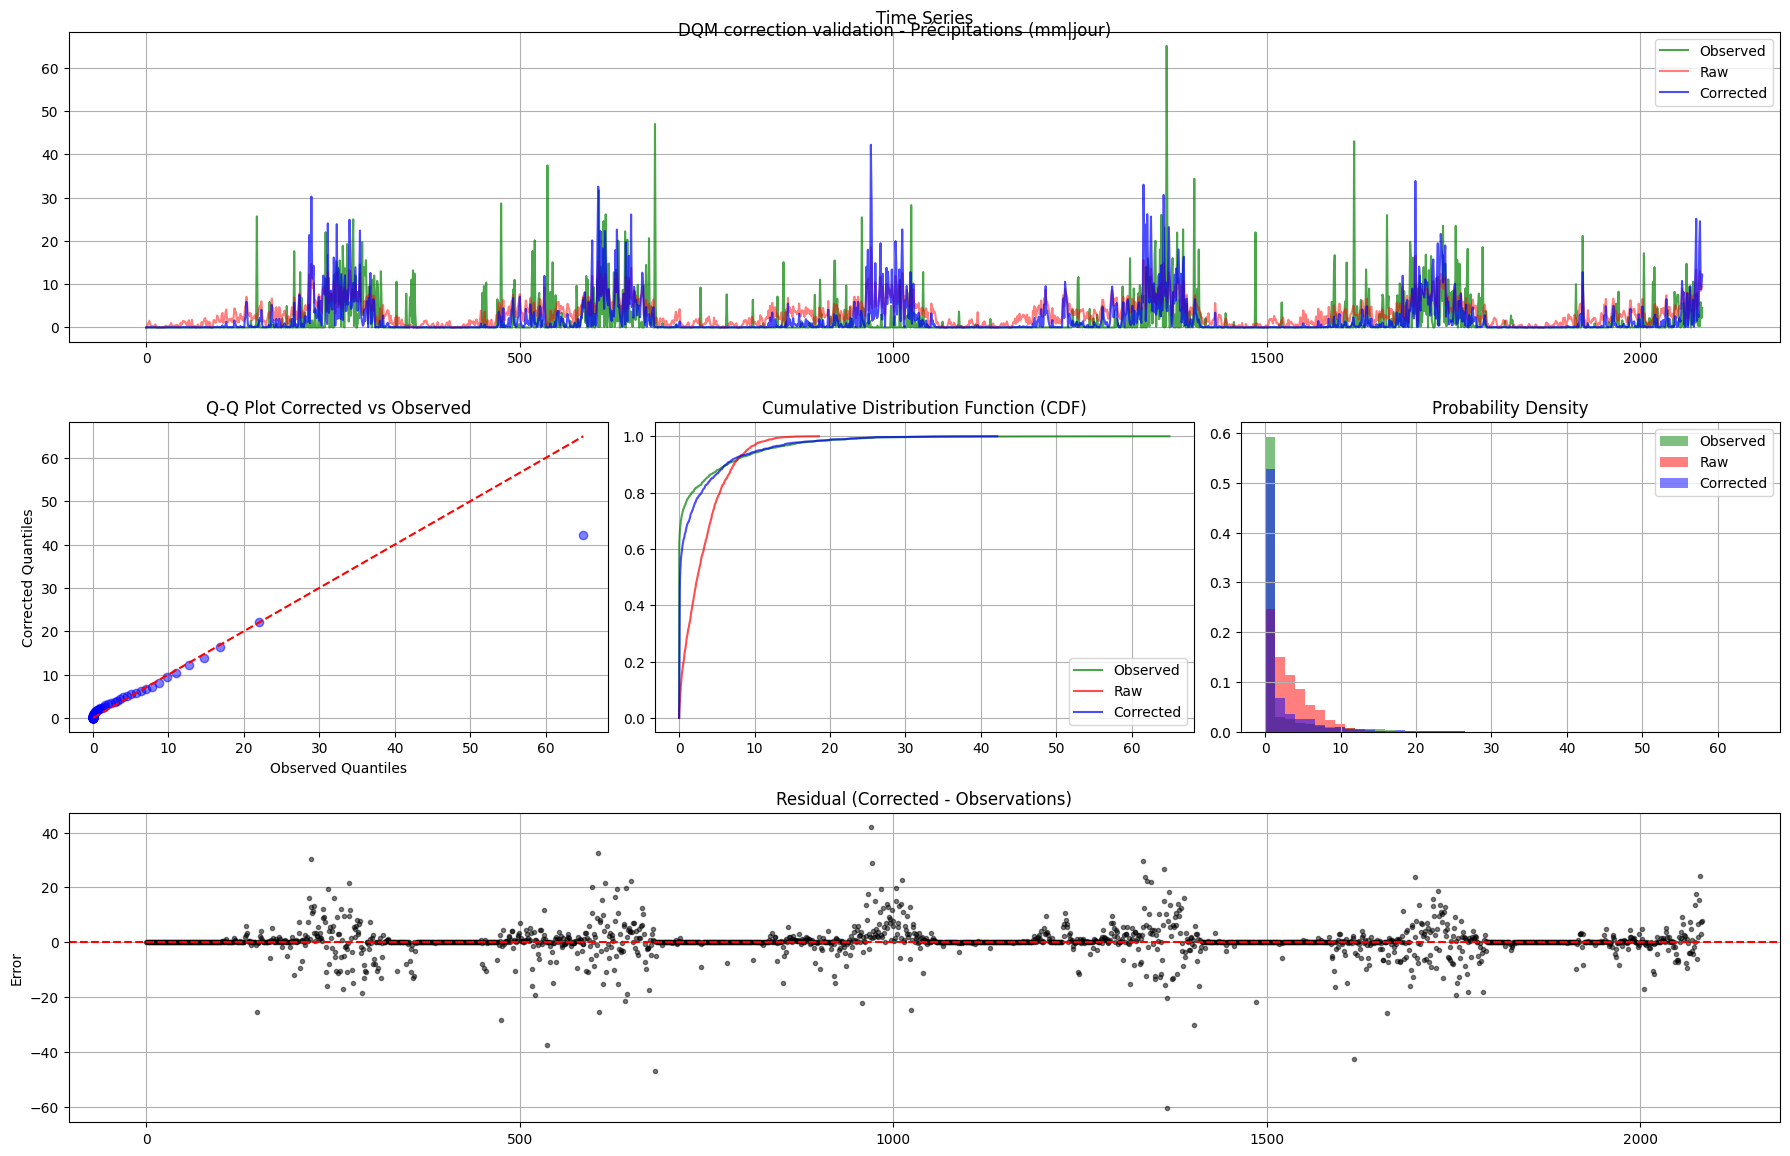

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_traning_metrics.csv
{'RMSE Brut': np.float32(4.8941746), 'RMSE Corrige': np.float64(5.519368340052948), 'Biais Brut': np.float32(1.3912498), 'Biais Corrige': np.float64(0.22846477205860344), 'Corrélation Brut': np.float64(0.3056393849982053), 'Corrélation Corrige': np.float64(0.24370358941434225), 'KS-test p-value': np.float64(1.0907341360500466e-300)}


In [ ]:
# Application aux projections futures
corrected_test = dqm.apply_dqm(
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrector
)

step = "validation"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=_obs_for_corrector.loc[ind_test , 'precip'].values,
        raw=_hist_for_corrector.loc[ind_test , 'precip'].values,
        corrected=corrected_test,
        directory=directory_validation,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_validation)
print(metrics_test)

In [ ]:
extends_metrics_test = dqm.calculate_extended_metrics(
    _obs_for_corrector.loc[ind_test , 'precip'].values,
    _hist_for_corrector.loc[ind_test , 'precip'].values,
    corrected_test)

manage_files.save_metrics(extends_metrics_test, 'dqm_traning_extends_metrics', directory_validation)

print(extends_metrics_test)

Metrics saved to /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/dqm_traning_extends_metrics
{'RMSE Brut': np.float32(4.8941746), 'RMSE Corrige': np.float64(5.519368340052948), 'Biais Brut': np.float32(1.3912498), 'Biais Corrige': np.float64(0.22846477205860344), 'R95p Brut': np.float32(-2.1019278), 'R95p Corrige': np.float64(-0.5214541829983261), 'Dry Days Brut': np.int64(-1264), 'Dry Days Corrige': np.int64(-383), 'KS-test p-value': np.float64(1.0907341360500466e-300)}


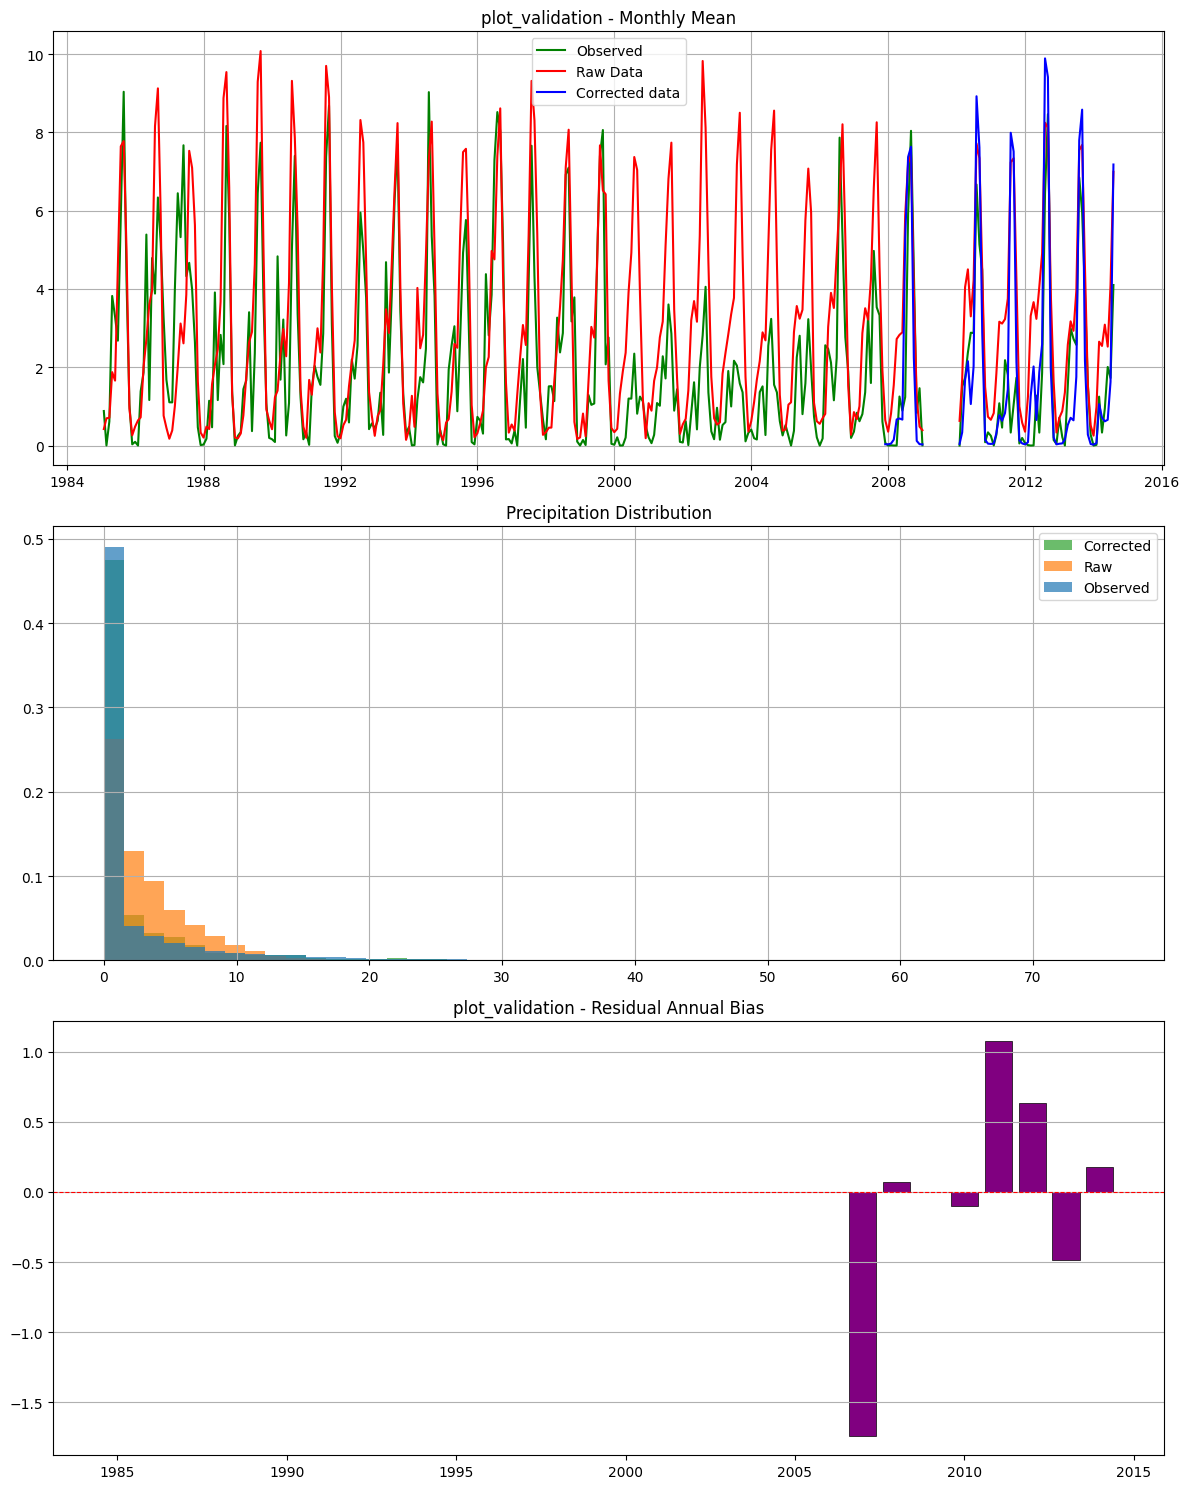

In [ ]:
corrected_test_df = pd.DataFrame({'time': _obs_for_corrector.loc[ind_test, 'time'].values, 'precip': corrected_test})

FIG_ = dqm.plot_climate_validation(
    _obs_for_corrector,
    _hist_for_corrector,
    corrected_test_df,
    "plot_validation",
    directory_validation,
    aggr='M')

In [ ]:
print(_scenar.columns)
_scenar.rename(columns={'pr': 'precip'}, inplace=True)

_scenar.dropna(subset=['time', 'precip'], inplace=True) # Supprime les lignes où 'precip' est NaN
_scenar.reset_index(drop=True, inplace=True) # Remet l'index à 0, 1, 2...
df_model = _scenar.copy()

Index(['time', 'precip'], dtype='object')


/content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/dqm_précipitations (mm|jour).png


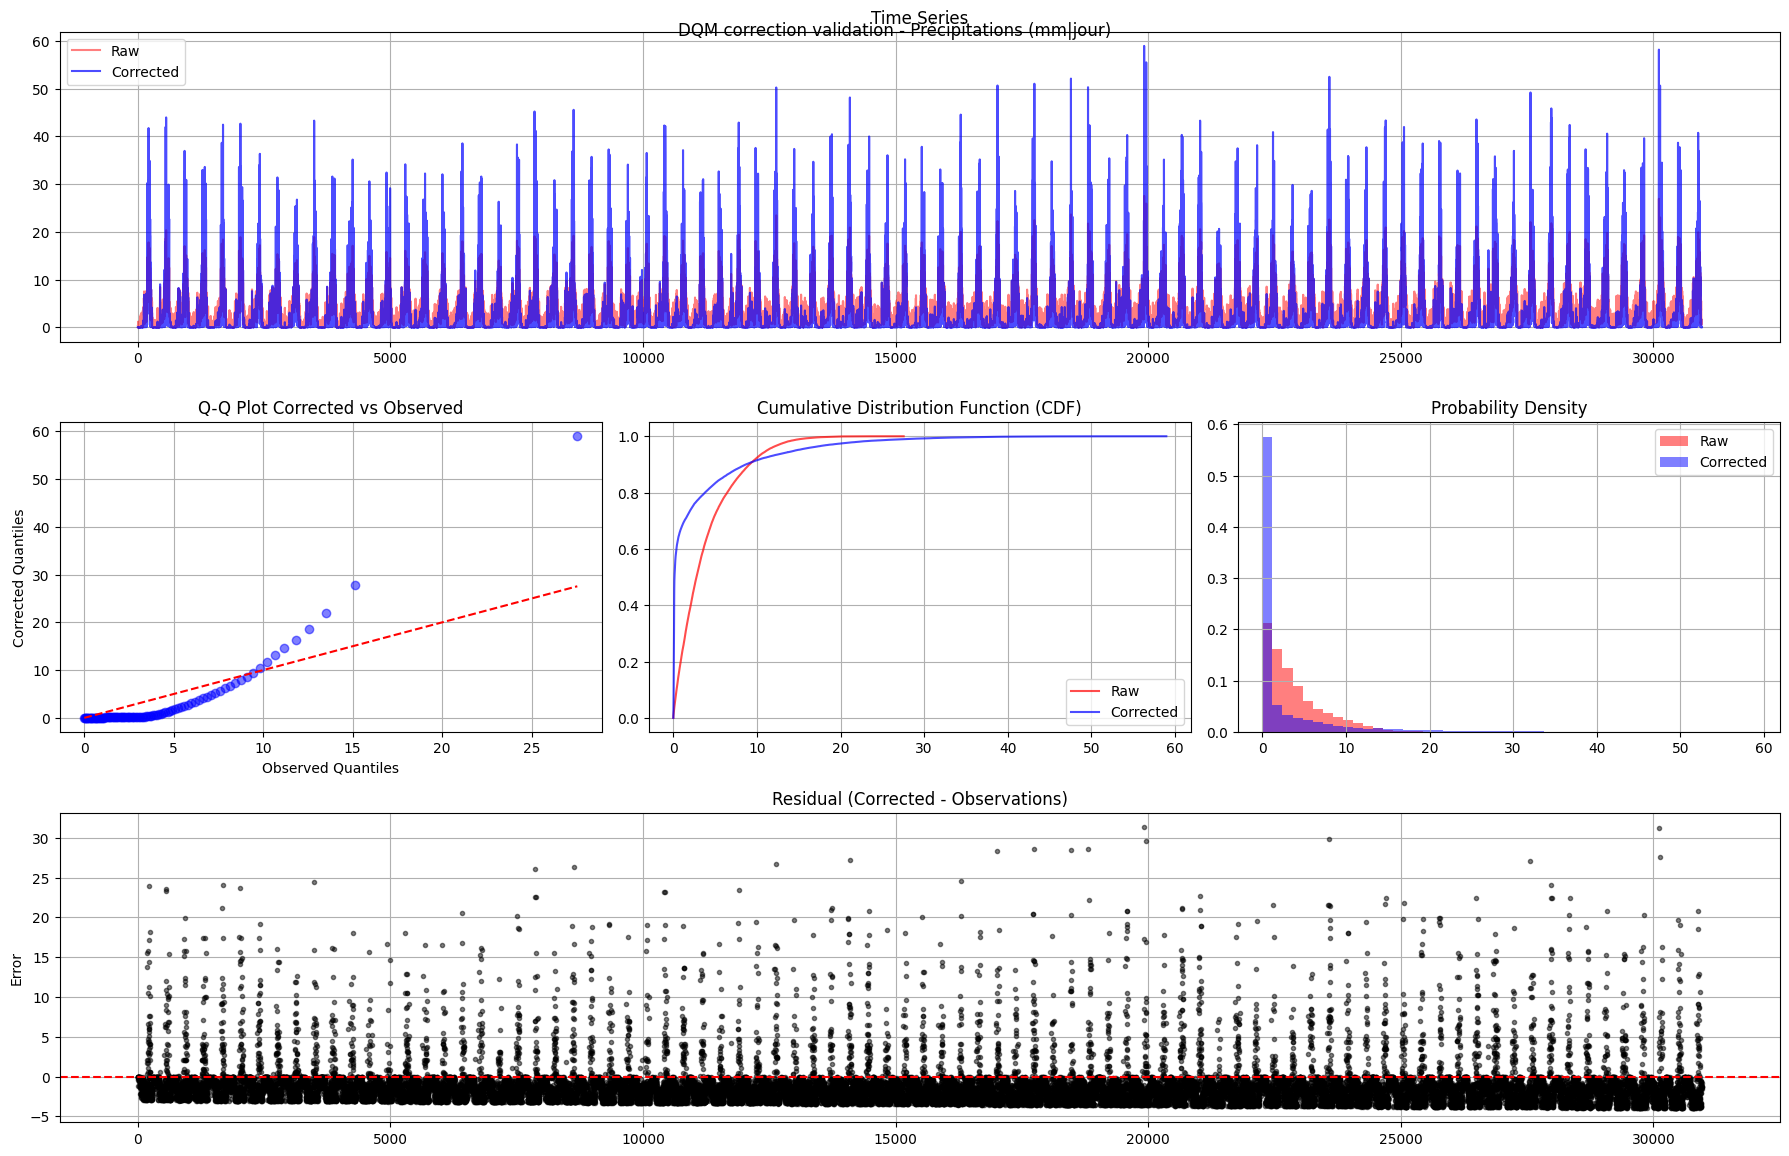

-1


In [ ]:
# Application aux projections futures
projection = dqm.apply_dqm(
    df_model['precip'].values,
    corrector)
projection_df = pd.DataFrame({'time': df_model['time'].values, 'precip_projection': projection})
projection_df.to_csv(directory_projection + f"projection_{scenario}.csv")

step = "projection"
# Validation sur la période de test
metrics_test = dqm.validate_dqm_correction(
        obs=None,
        raw=df_model['precip'].values,
        corrected=projection,
        directory=directory_projection,
        #corrector=corrector,
        variable_name="Précipitations (mm|jour)"
    )
#manage_files.save_metrics(metrics_test, 'dqm_traning_metrics.csv', directory_projection)
print(metrics_test)

In [ ]:
!pip install mlflow

In [ ]:
mlflow.end_run()

#LSTM

Période d'entraînement (Calib DQM & Train LSTM): 1985-01-01 00:00:00 à 2008-12-30 00:00:00
Période de validation (Valid DQM & Test LSTM): 2008-12-31 00:00:00 à 2015-01-01 00:00:00
Période de projection: 2015-01-01 00:00:00 à 2100-12-31 00:00:00

Taille de la fenêtre temporelle (window_size): 31

Nombre de jours dans df_model original: 30960
Nombre de jours dans df_scenar_cleaned (après dropna): 30960

Correction DQM appliquée sur les données du modèle historique et scénario.
df_hist_corrected shape: (10417, 3)
df_scenar_corrected shape: (30960, 3)

Nombre de jours/séquences pour l'entraînement LSTM: 8716
Shape des séquences d'entraînement X: (8716, 31, 8)
Shape de la cible d'entraînement y: (8716,)

Nombre de jours/séquences pour le test LSTM: 1639
Shape des séquences de test X: (1639, 31, 8)
Shape de la cible de test y: (1639,)

Shapes après mise à l'échelle (avec séquences):
X_train_scaled: (8716, 31, 8)
y_train_scaled: (8716, 1)
X_test_scaled: (1639, 31, 8)
y_test_scaled: (1639, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Entraînement du modèle LSTM...


Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 11.3557 - mae: 1.6513

218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - loss: 11.3442 - mae: 1.6507 - val_loss: 7.5621 - val_mae: 1.1743
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.5137 - mae: 1.6273

218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 9.5059 - mae: 1.6268 - val_loss: 6.8815 - val_mae: 1.1936
Epoch 3/20
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.2517 - mae: 1.5939

218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 9.2367 - mae: 1.5930 - val_loss: 6.7001 - val_mae: 1.2665
Epoch 4/20
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.1293 - mae: 1.5923

218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 9.1145 - mae: 1.5914 - val_loss: 6.4750 - val_mae: 1.2865
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 8.9732 - mae: 1.5907 - val_loss: 6.4958 - val_mae: 1.2986
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.9207 - mae: 1.5907

218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 8.9134 - mae: 1.5902 - val_loss: 6.3674 - val_mae: 1.3193
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 8.8514 - mae: 1.5897 - val_loss: 6.4255 - val_mae: 1.2699
Epoch 8/20
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.7641 - mae: 1.5942

218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 8.7498 - mae: 1.5930 - val_loss: 6.3237 - val_mae: 1.3121
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 8.6604 - mae: 1.5866 - val_loss: 6.3591 - val_mae: 1.2218
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 8.6353 - mae: 1.5978 - val_loss: 6.4432 - val_mae: 1.2745
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 8.5688 - mae: 1.6027 - val_loss: 6.4835 - val_mae: 1.2695
Epoch 12/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 8.5060 - mae: 1.6024 - val_loss: 6.5622 - val_mae: 1.2393
Epoch 13/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 8.4440 - mae: 1.6045 - val_loss: 6.5915 - val_mae: 1.2970
Epoch 14/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 8.4599 - mae: 1.6042 - val_loss: 7.0154 - val_mae: 1.3190
Epoch 15/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 8.4600 - mae: 1.6144 - val_loss: 6.6740 - val_mae: 1.4117
Epoch 16/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 20s 

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_34 (GRU)                    │ (None, 31, 72)         │        17,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 31, 72)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 31, 72)         │           288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_35 (GRU)                    │ (None, 48)             │        17,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,565 (416.27 KB)

 Trainable params: 35,473 (138.57 KB)

 Non-trainable params: 144 (576.00 B)

 Optimizer params: 70,948 (277.14 KB)


Évaluation du modèle sur la période de validation...
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
RMSE (LSTM Train): 4.7124
R² (LSTM Train): 0.0358
RMSE (LSTM Test): 4.8684
R² (LSTM Test): -0.0283

Métriques LSTM sauvegardées à: /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/addis_ababa_ssp245_lstm_metrics_validation_ws31.csv
Figure de validation LSTM sauvegardée à: /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/validation/addis_ababa_ssp245_lstm_validation_plot_ws31.png

Début de la période pour la construction des séquences de projection: 2014-12-02 00:00:00

Réalisation de la projection future...
967/967 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
!!! DEBUG PROJECTION !!! Longueur projection_plot_dates: 30930, Longueur y_projection_pred_clipped: 30929
Longueur full_projection_data_for_sequences: 30960, window_size: 31
Nombre attendu de séquences/prédictions: 30929
Nouvelle longueur pr


Tous les résultats de projection sauvegardés dans: /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/
Figure de projection sauvegardée à: /content/drive/MyDrive/Precipitation_Projection_AIMS/data/addis_ababa/ssp245/projection/addis_ababa_ssp245_projection_plot_ws31.png

--- Processus terminé avec succès ---


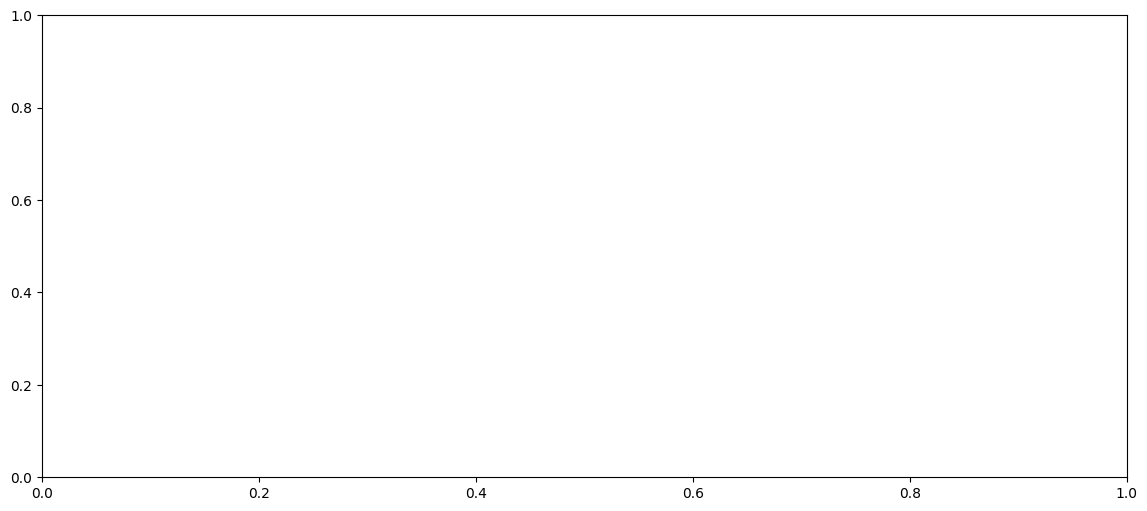

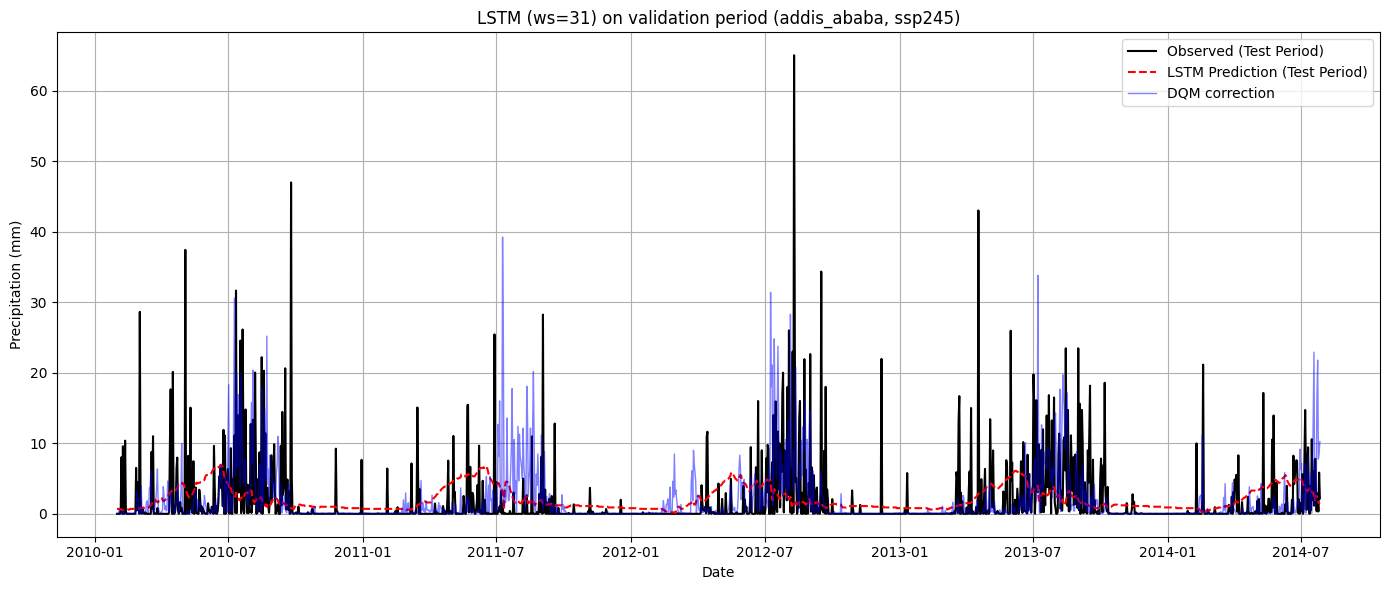

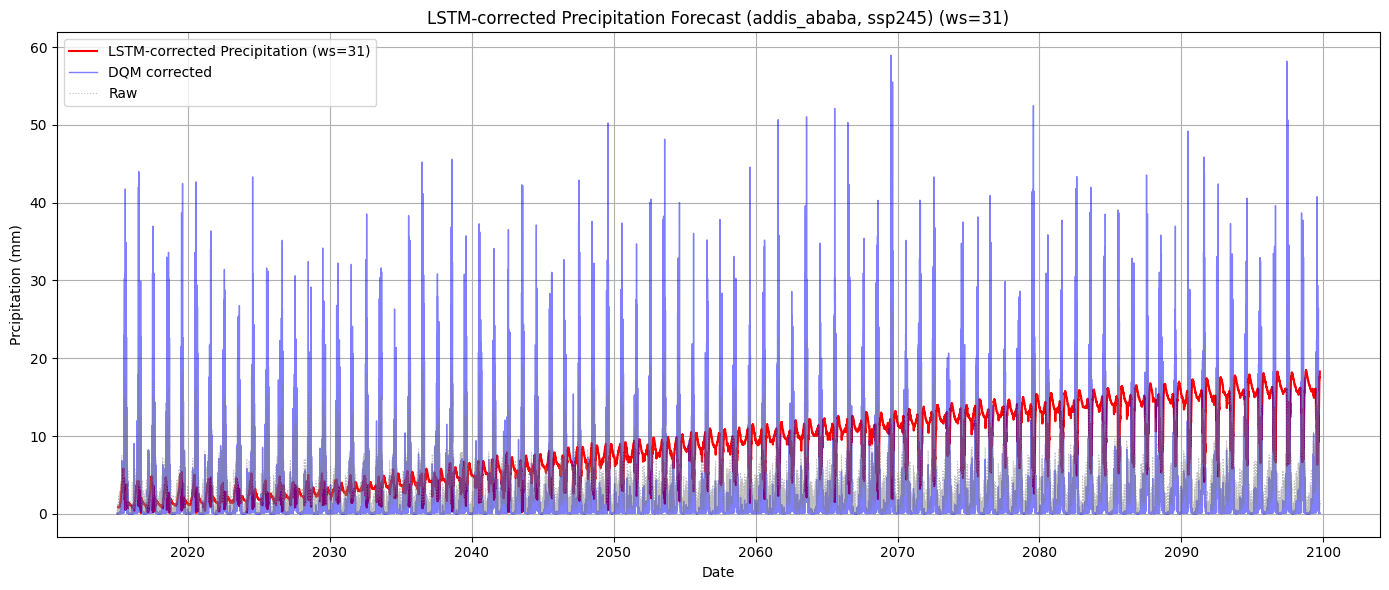

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pickle
import os
import math
import mlflow  # Optionnel pour le tracking
import sys

# --- Supposons que ces variables et dataframes sont déjà définis et disponibles ---
# calib_start, calib_end, valid_start, valid_end, projection_start, projection_end
# _obs_for_corrector (Observations, e.g., 1985-2014, colonne 'precip')
# _hist_for_corrector (Modèle Historique, e.g., 1985-2014, colonne 'precip')
# df_model (Modèle Scénario, e.g., 1985-2100, colonne 'precip')
# corrector (l'objet DQM corrector entraîné précédemment)
# directory_training, directory_validation, directory_projection
# site, scenario

print(f"Période d'entraînement (Calib DQM & Train LSTM): {calib_start} à {calib_end}")
print(f"Période de validation (Valid DQM & Test LSTM): {valid_start} à {valid_end}")
print(f"Période de projection: {projection_start} à {projection_end}")

# --- Hyperparamètres pour la séquence temporelle ---
window_size = 31 # Taille de la fenêtre (nombre de jours passés)
print(f"\nTaille de la fenêtre temporelle (window_size): {window_size}")

# --- Préparation des données ---
df_scenar_cleaned = df_model.copy()
assert df_scenar_cleaned['time'].isnull().sum() == 0, "Null values found in df_scenar_cleaned['time']."
df_scenar_cleaned.dropna(subset=['precip'], inplace=True)
df_scenar_cleaned = df_scenar_cleaned.sort_values('time').reset_index(drop=True)
print(f"\nNombre de jours dans df_model original: {len(df_model)}")
print(f"Nombre de jours dans df_scenar_cleaned (après dropna): {len(df_scenar_cleaned)}")

# Appliquer la correction DQM
hist_corrected_values = dqm.apply_dqm(_hist_for_corrector['precip'].values, corrector)
# hist_corrected_values = _hist_for_corrector['precip'].values   # attention
df_hist_corrected = _hist_for_corrector.copy()
df_hist_corrected['precip_corrected'] = hist_corrected_values

scenar_corrected_values = dqm.apply_dqm(df_scenar_cleaned['precip'].values, corrector)
df_scenar_corrected = df_scenar_cleaned.copy()
df_scenar_corrected['precip_corrected'] = scenar_corrected_values

print("\nCorrection DQM appliquée sur les données du modèle historique et scénario.")
print(f"df_hist_corrected shape: {df_hist_corrected.shape}")
print(f"df_scenar_corrected shape: {df_scenar_corrected.shape}")

# --- Ajout des Caractéristiques ---
def add_features(df, precip_col='precip'):
    df['day_of_year'] = df['time'].dt.dayofyear
    df['month'] = df['time'].dt.month
    df['sin_doy'] = np.sin(2 * math.pi * df['day_of_year'] / 365.25)
    df['cos_doy'] = np.cos(2 * math.pi * df['day_of_year'] / 365.25)
    df['sin_month'] = np.sin(2 * math.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * math.pi * df['month'] / 12)
    df['year'] = df['time'].dt.year

    if 'precip_corrected' in df.columns:
        df['rolling_mean_7'] = df['precip_corrected'].rolling(window=7).mean().fillna(0)
        df['rolling_std_7'] = df['precip_corrected'].rolling(window=7).std().fillna(0)
    return df

df_hist_corrected = add_features(df_hist_corrected, precip_col='precip_corrected')
_obs_for_corrector_features = add_features(_obs_for_corrector.copy(), precip_col='precip')
df_scenar_corrected = add_features(df_scenar_corrected, precip_col='precip_corrected')

# --- Préparer les Données en Séquences ---
# Fonction corrigée pour créer les séquences
"""
def create_sequences(data, window_size, feature_cols):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Sélectionner la fenêtre de 'window_size' jours
        window_data = data.iloc[i:(i + window_size)]

        # Extraire les valeurs des colonnes de features pour cette fenêtre
        # Cela donnera un tableau numpy de forme (window_size, nombre_de_features)
        seq_x = window_data[feature_cols].values

        print("windows_data columns = ", window_data.columns)

        # La cible y est la précipitation OBSERVÉE du DERNIER jour de la fenêtre
        seq_y = window_data.iloc[-1]['precip_obs'] # -1 pour le dernier jour de la fenêtre

        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
"""

def create_sequences(data, window_size, feature_cols, include_target=True):
    X, y = [], []
    for i in range(len(data) - window_size):
        # Sélectionner la fenêtre de 'window_size' jours
        window_data = data.iloc[i:(i + window_size)]

        # Extraire les valeurs des colonnes de features pour cette fenêtre
        seq_x = window_data[feature_cols].values

        if include_target:
             # La cible y est la précipitation OBSERVÉE du DERNIER jour de la fenêtre
             # Assurez-vous que 'precip_obs' existe dans le dataframe si include_target est True
             if 'precip_obs' not in window_data.columns:
                  raise ValueError("La colonne 'precip_obs' est requise lorsque include_target est True.")
             seq_y = window_data.iloc[-1]['precip_obs']
             y.append(seq_y)

        X.append(seq_x)

    if include_target:
        return np.array(X), np.array(y)
    else:
        return np.array(X) # Retourner seulement X pour la projection


feature_cols = ['precip_corrected', 'sin_doy', 'cos_doy', 'sin_month', 'cos_month', 'year', 'rolling_mean_7', 'rolling_std_7']

# Préparation données d'entraînement
lstm_train_input_features = df_hist_corrected[
    (df_hist_corrected['time'] >= calib_start) & (df_hist_corrected['time'] <= calib_end)
].copy()

lstm_train_output_features = _obs_for_corrector_features[
    (_obs_for_corrector_features['time'] >= calib_start) & (_obs_for_corrector_features['time'] <= calib_end)
].copy()

lstm_train_merged_seq = pd.merge(
    lstm_train_input_features[['time'] + feature_cols],
    lstm_train_output_features[['time', 'precip']],
    on='time',
    how='inner'
)
lstm_train_merged_seq.rename(columns={'precip': 'precip_obs'}, inplace=True)
lstm_train_merged_seq = lstm_train_merged_seq.sort_values('time').reset_index(drop=True)
lstm_train_merged_seq['features'] = lstm_train_merged_seq[feature_cols].apply(list, axis=1)

# Créer séquences d'entraînement
X_train_lstm, y_train_lstm = create_sequences(lstm_train_merged_seq, window_size, feature_cols)

print(f"\nNombre de jours/séquences pour l'entraînement LSTM: {len(X_train_lstm)}")
print(f"Shape des séquences d'entraînement X: {X_train_lstm.shape}")
print(f"Shape de la cible d'entraînement y: {y_train_lstm.shape}")

# Préparation données de test
lstm_test_input_features = df_hist_corrected[
    (df_hist_corrected['time'] >= valid_start) & (df_hist_corrected['time'] <= valid_end)
].copy()

lstm_test_output_features = _obs_for_corrector_features[
    (_obs_for_corrector_features['time'] >= valid_start) & (_obs_for_corrector_features['time'] <= valid_end)
].copy()

lstm_test_merged_seq = pd.merge(
    lstm_test_input_features[['time'] + feature_cols],
    lstm_test_output_features[['time', 'precip']],
    on='time',
    how='inner'
)
lstm_test_merged_seq.rename(columns={'precip': 'precip_obs'}, inplace=True)
lstm_test_merged_seq = lstm_test_merged_seq.sort_values('time').reset_index(drop=True)
lstm_test_merged_seq['features'] = lstm_test_merged_seq[feature_cols].apply(list, axis=1)

# Créer séquences de test
X_test_lstm, y_test_lstm = create_sequences(lstm_test_merged_seq, window_size, feature_cols)

print(f"\nNombre de jours/séquences pour le test LSTM: {len(X_test_lstm)}")
print(f"Shape des séquences de test X: {X_test_lstm.shape}")
print(f"Shape de la cible de test y: {y_test_lstm.shape}")

# --- CORRECTION PRINCIPALE: Mise à l'échelle des séquences ---
# Aplatir les séquences pour le fitting
n_train_seqs, n_steps, n_features = X_train_lstm.shape
X_train_flat = X_train_lstm.reshape(-1, n_features)

scaler_X = RobustScaler()
# scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X_train_flat)

# Appliquer la transformation et remettre en forme
X_train_scaled = scaler_X.transform(X_train_flat).reshape(n_train_seqs, n_steps, n_features)

# Même traitement pour les données de test
n_test_seqs, _, _ = X_test_lstm.shape
X_test_flat = X_test_lstm.reshape(-1, n_features)
X_test_scaled = scaler_X.transform(X_test_flat).reshape(n_test_seqs, n_steps, n_features)

# Scaler pour les cibles
scaler_y = RobustScaler()
#scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train_lstm.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_lstm.reshape(-1, 1))

print(f"\nShapes après mise à l'échelle (avec séquences):")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"y_train_scaled: {y_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_test_scaled: {y_test_scaled.shape}")

# --- Construire le modèle LSTM ---
"""
model_lstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh',
                      kernel_regularizer=l2(0.001))),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001), activation='tanh')),
    Dropout(0.2),
    Dense(16, activation='relu'),

    #Bidirectional(LSTM(32, activation='tanh')),
    Dense(1)
])
"""

"""
model_lstm = Sequential([
    Bidirectional(LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(4, activation='relu'),
    Dense(1)
])
"""

"""
model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),

    Dense(4, activation='relu'),
    Dense(1)
])
"""
from tensorflow.keras.layers import GRU, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2

model_lstm = Sequential([
    GRU(72, activation='relu',
        input_shape=(window_size, X_train_scaled.shape[2]),
        return_sequences=True,
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.3),
    BatchNormalization(),

    GRU(48, activation='relu',
        kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    #Dropout(0.3),
    #BatchNormalization(),

    #Dense(36, activation='relu'),
    #Dense(24, activation='relu'),
    Dense(1, activation='relu')  # linear pour régression
])



"""
model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(window_size, X_train_scaled.shape[2]), kernel_regularizer=l2(0.001)),
    LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(4, activation='relu'),
    Dense(1)
])
"""

model_lstm.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])


# --- Entraînement avec améliorations ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Augmenté
    min_delta=0.001,  # Seuil minimum d'amélioration
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Début du tracking MLflow (optionnel)
mlflow.start_run()
mlflow.tensorflow.autolog()

print("\nEntraînement du modèle LSTM...")
history = model_lstm.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    batch_size=32,
    verbose=1,
    shuffle=False,
    validation_split=0.2,
    #callbacks=[early_stopping, lr_scheduler]
)
print("Entraînement terminé.")

print("\nModèle LSTM configuré.")
model_lstm.summary()

# --- Évaluation du modèle ---
print("\nÉvaluation du modèle sur la période de validation...")
y_test_pred_scaled = model_lstm.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred_clipped = np.clip(y_test_pred, 0, None)

# Post-traitement avec arrondi
def postprocess_precip(predictions):
    predictions = np.clip(predictions, 0, None)
    return np.round(predictions, 1)  # Arrondi à 1 décimale

y_test_pred_processed = postprocess_precip(y_test_pred_clipped)

# Calcul des métriques
rmse_lstm_test = np.sqrt(mean_squared_error(y_test_lstm, y_test_pred_processed))
r2_lstm_test = r2_score(y_test_lstm, y_test_pred_processed)

# Optionnel: Évaluation sur les données d'entraînement
y_train_pred_scaled = model_lstm.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_train_pred_processed = postprocess_precip(y_train_pred)
rmse_lstm_train = np.sqrt(mean_squared_error(y_train_lstm, y_train_pred_processed))
r2_lstm_train = r2_score(y_train_lstm, y_train_pred_processed)

print(f"RMSE (LSTM Train): {rmse_lstm_train:.4f}")
print(f"R² (LSTM Train): {r2_lstm_train:.4f}")
print(f"RMSE (LSTM Test): {rmse_lstm_test:.4f}")
print(f"R² (LSTM Test): {r2_lstm_test:.4f}")

# --- Sauvegarde des résultats ---
lstm_metrics = {
    'RMSE_Train': rmse_lstm_train,
    'R2_Train': r2_lstm_train,
    'RMSE_Test': rmse_lstm_test,
    'R2_Test': r2_lstm_test,
    'Window_Size': window_size,
    'Epochs_trained': len(history.history['loss'])
}
lstm_metrics_df = pd.DataFrame([lstm_metrics])
metrics_filepath = os.path.join(directory_validation, f'{site}_{scenario}_lstm_metrics_validation_ws{window_size}.csv')
lstm_metrics_df.to_csv(metrics_filepath, index=False)
print(f"\nMétriques LSTM sauvegardées à: {metrics_filepath}")

# --- Visualisation des résultats de test ---
#test_plot_dates = lstm_test_merged_seq['time'].iloc[window_size-1:].reset_index(drop=True)
test_plot_dates = lstm_test_merged_seq['time'].iloc[window_size:].values


fig_test, ax_test = plt.subplots(figsize=(14, 6))
fig_test, ax_test = plt.subplots(figsize=(14, 6))

# print(len(test_plot_dates), len(y_test_lstm))
# print(len(test_plot_dates), len(y_test_pred_processed.flatten()))
# print(len(test_plot_dates), len(lstm_test_merged_seq['precip_corrected'].iloc[window_size:].values))

# sys.exit()

ax_test.plot(test_plot_dates, y_test_lstm, label='Observed (Test Period)', color='black', linewidth=1.5)
ax_test.plot(test_plot_dates, y_test_pred_processed.flatten(), label='LSTM Prediction (Test Period)', color='red', linewidth=1.5, linestyle='--')
ax_test.plot(test_plot_dates, lstm_test_merged_seq['precip_corrected'].iloc[window_size:].values, label='DQM correction', color='blue', alpha=0.5, linewidth=1)

ax_test.set_title(f"LSTM (ws={window_size}) on validation period ({site}, {scenario})")
ax_test.set_xlabel("Date")
ax_test.set_ylabel("Precipitation (mm)")
ax_test.legend()
ax_test.grid(True)
plt.tight_layout()

test_fig_filepath = os.path.join(directory_validation, f'{site}_{scenario}_lstm_validation_plot_ws{window_size}.png')
fig_test.savefig(test_fig_filepath)
print(f"Figure de validation LSTM sauvegardée à: {test_fig_filepath}")

# --- Projection future ---
projection_sequence_start_date = projection_start - pd.Timedelta(days=window_size - 1)
print(f"\nDébut de la période pour la construction des séquences de projection: {projection_sequence_start_date}")

full_projection_data_for_sequences = df_scenar_corrected[
    (df_scenar_corrected['time'] >= projection_sequence_start_date) & (df_scenar_corrected['time'] <= projection_end)
].copy()
full_projection_data_for_sequences['features'] = full_projection_data_for_sequences[feature_cols].apply(list, axis=1)

X_projection_lstm_sequences = create_sequences(full_projection_data_for_sequences, window_size, feature_cols, include_target=False)

# Mise à l'échelle des séquences de projection
n_proj_seqs, n_steps, n_features = X_projection_lstm_sequences.shape
X_projection_flat = X_projection_lstm_sequences.reshape(-1, n_features)
X_projection_scaled = scaler_X.transform(X_projection_flat).reshape(n_proj_seqs, n_steps, n_features)

print(f"\nRéalisation de la projection future...")
y_projection_pred_scaled = model_lstm.predict(X_projection_scaled)
y_projection_pred = scaler_y.inverse_transform(y_projection_pred_scaled)
y_projection_pred_processed = postprocess_precip(y_projection_pred)

# Limiter les prédictions à des valeurs non négatives
y_projection_pred_clipped = np.clip(y_projection_pred, 0, None) # <-- y_projection_pred_clipped est défini ici

# projection_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size-1:].reset_index(drop=True)

projection_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size - 1 : len(full_projection_data_for_sequences)].reset_index(drop=True)

# Une manière alternative (et souvent plus sûre si les indices ne sont pas consécutifs après filtering/merging)
# est de prendre le nombre exact de dates nécessaires à partir du bon point de départ.
# test_plot_dates = full_projection_data_for_sequences['time'].iloc[window_size - 1:].reset_index(drop=True) # C'est déjà ce que vous aviez, mais potentiellement source d'erreur si l'indexation finale est tricky

# Assurons-nous que la longueur de projection_plot_dates correspond au nombre de prédictions
num_predictions = len(y_projection_pred_clipped)
expected_plot_dates_length = num_predictions

if len(projection_plot_dates) != expected_plot_dates_length:
    print(f"!!! DEBUG PROJECTION !!! Longueur projection_plot_dates: {len(projection_plot_dates)}, Longueur y_projection_pred_clipped: {num_predictions}")
    print(f"Longueur full_projection_data_for_sequences: {len(full_projection_data_for_sequences)}, window_size: {window_size}")
    print(f"Nombre attendu de séquences/prédictions: {len(full_projection_data_for_sequences) - window_size}")

    # Si cela ne correspond toujours pas, on force la sélection pour avoir le bon nombre d'éléments
    projection_plot_dates = full_projection_data_for_sequences['time'].iloc[len(full_projection_data_for_sequences) - num_predictions:].reset_index(drop=True)
    print(f"Nouvelle longueur projection_plot_dates après correction forcée: {len(projection_plot_dates)}")


# --- Sauvegarde des projections ---
raw_proj_df = df_model[
    (df_model['time'] >= projection_start) & (df_model['time'] <= projection_end)
][['time', 'precip']].copy()
raw_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_raw.csv')
raw_proj_df.to_csv(raw_proj_filepath, index=False)

dqm_corr_proj_df = df_scenar_corrected[
    (df_scenar_corrected['time'] >= projection_start) & (df_scenar_corrected['time'] <= projection_end)
][['time', 'precip_corrected']].copy()
dqm_corr_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_dqm_corrected.csv')
dqm_corr_proj_df.to_csv(dqm_corr_proj_filepath, index=False)

lstm_proj_df = pd.DataFrame({
    'time': projection_plot_dates.values,
    'precip_lstm_corrected': y_projection_pred_processed.flatten()
})
lstm_proj_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_lstm_corrected_ws{window_size}.csv')
lstm_proj_df.to_csv(lstm_proj_filepath, index=False)

model_lstm_filepath = os.path.join(directory_projection, f'{site}_{scenario}_lstm_model_ws{window_size}.h5')
model_lstm.save(model_lstm_filepath)

scaler_X_filepath = os.path.join(directory_projection, f'{site}_{scenario}_scaler_X_ws{window_size}.pkl')
scaler_y_filepath = os.path.join(directory_projection, f'{site}_{scenario}_scaler_y_ws{window_size}.pkl')
with open(scaler_X_filepath, 'wb') as f:
    pickle.dump(scaler_X, f)
with open(scaler_y_filepath, 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"\nTous les résultats de projection sauvegardés dans: {directory_projection}")

# --- Visualisation de la projection ---
fig_proj, ax_proj = plt.subplots(figsize=(14, 6))
ax_proj.plot(lstm_proj_df['time'], lstm_proj_df['precip_lstm_corrected'],
             label=f'LSTM-corrected Precipitation (ws={window_size})', color='red', linewidth=1.5)
ax_proj.plot(dqm_corr_proj_df['time'], dqm_corr_proj_df['precip_corrected'],
             label='DQM corrected', color='blue', alpha=0.5, linewidth=1)
ax_proj.plot(raw_proj_df['time'], raw_proj_df['precip'],
             label='Raw', color='gray', alpha=0.5, linewidth=0.8, linestyle=':')

ax_proj.set_title(f"LSTM-corrected Precipitation Forecast ({site}, {scenario}) (ws={window_size})")
ax_proj.set_xlabel("Date")
ax_proj.set_ylabel("Prcipitation (mm)")
ax_proj.legend()
ax_proj.grid(True)
plt.tight_layout()

proj_fig_filepath = os.path.join(directory_projection, f'{site}_{scenario}_projection_plot_ws{window_size}.png')
fig_proj.savefig(proj_fig_filepath)
print(f"Figure de projection sauvegardée à: {proj_fig_filepath}")

# Fin du tracking MLflow (optionnel)
mlflow.end_run()

print("\n--- Processus terminé avec succès ---")


Nombre de jours pour l'entraînement LSTM: 8747
Nombre de jours pour le test LSTM: 1670
